In [1]:
install.packages('IRkernel')
IRkernel::installspec()


library(dplyr)
library(tidyverse)
library(lubridate)


The downloaded binary packages are in
	/var/folders/43/bn9297xx5b35xcfsk5bcjf9c0000gn/T//RtmpKauyvi/downloaded_packages



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.5
v ggplot2   3.5.1     v stringr   1.5.1
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
# Load datasets
features <- read.csv("features.csv")
stores <- read.csv("stores.csv")
train <- read.csv("train.csv")
test <- read.csv("test.csv")

In [5]:
# Convert Date columns to Date type
features$Date <- as.Date(features$Date, format="%Y-%m-%d")
test$Date <- as.Date(test$Date, format="%Y-%m-%d")
train$Date <- as.Date(train$Date, format="%Y-%m-%d")

head(features)
head(stores)
head(train)
head(test)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,1,2010-02-05,42.31,2.572,NA,NA,NA,NA,NA,211.0964,8.106,FALSE
2,1,2010-02-12,38.51,2.548,NA,NA,NA,NA,NA,211.2422,8.106,TRUE
3,1,2010-02-19,39.93,2.514,NA,NA,NA,NA,NA,211.2891,8.106,FALSE
4,1,2010-02-26,46.63,2.561,NA,NA,NA,NA,NA,211.3196,8.106,FALSE
5,1,2010-03-05,46.50,2.625,NA,NA,NA,NA,NA,211.3501,8.106,FALSE
6,1,2010-03-12,57.79,2.667,NA,NA,NA,NA,NA,211.3806,8.106,FALSE


,Store,Type,Size
,<int>,<chr>,<int>
1,1,A,151315
2,2,A,202307
3,3,B,37392
4,4,A,205863
5,5,B,34875
6,6,A,202505


,Store,Dept,Date,Weekly_Sales,IsHoliday
,<int>,<int>,<date>,<dbl>,<lgl>
1,1,1,2010-02-05,24924.50,FALSE
2,1,1,2010-02-12,46039.49,TRUE
3,1,1,2010-02-19,41595.55,FALSE
4,1,1,2010-02-26,19403.54,FALSE
5,1,1,2010-03-05,21827.90,FALSE
6,1,1,2010-03-12,21043.39,FALSE


,Store,Dept,Date,IsHoliday
,<int>,<int>,<date>,<lgl>
1,1,1,2012-11-02,FALSE
2,1,1,2012-11-09,FALSE
3,1,1,2012-11-16,FALSE
4,1,1,2012-11-23,TRUE
5,1,1,2012-11-30,FALSE
6,1,1,2012-12-07,FALSE


### Analyze Weekly Sales Trend

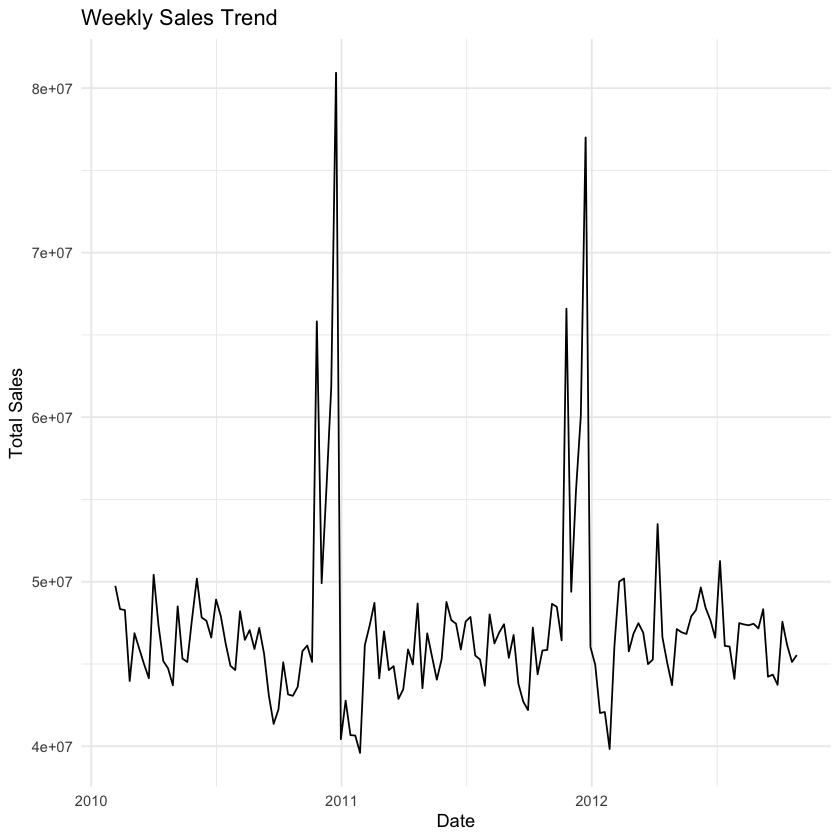

In [35]:
# Aggregate weekly sales for trend analysis
sales_trend <- train |>
  group_by(Date) |>
  summarize(Total_sales = sum(Weekly_Sales))

# PLot the sales trend
sales_trend |>
  ggplot(aes(x = Date, y = Total_sales)) +
  geom_line() +
  labs(
    title = "Weekly Sales Trend",
    x = "Date",
    y = "Total Sales"
  ) +
  theme_minimal()

### Analyze Seasonality

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


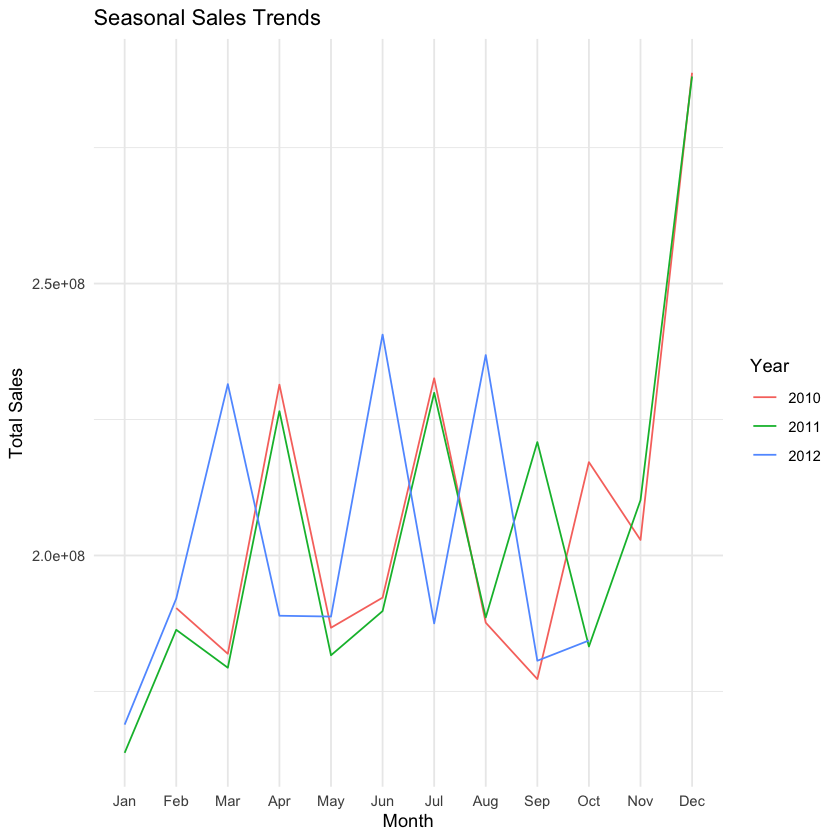

In [6]:
# Extract year and month
train <- train |>
    mutate(Year = year(Date), Month = month(Date, label = TRUE))

# Aggregate sales by month
monthly_sales <- train |>
    group_by(Year, Month) |>
    summarize(Total_Sales = sum(Weekly_Sales))

# Plot seasonal trends
monthly_sales |>
    ggplot(aes(x = Month, y = Total_Sales, group = Year, color = as.factor(Year))) +
    geom_line() +
    labs(
        title = "Seasonal Sales Trends",
        x = "Month",
        y = "Total Sales",
        color = "Year"
    ) +
    theme_minimal()

### Handle Missing Values in Features Dataset

In [7]:
# Check for missing values
missing_values <- colSums(is.na(features))
print(missing_values)

       Store         Date  Temperature   Fuel_Price    MarkDown1    MarkDown2 
           0            0            0            0         4158         5269 
   MarkDown3    MarkDown4    MarkDown5          CPI Unemployment    IsHoliday 
        4577         4726         4140          585          585            0 


In [8]:
# Replace missing values with median or a placeholder (if needed)
features <- features %>%
  mutate(across(starts_with("MarkDown"), ~ ifelse(is.na(.), median(., na.rm = TRUE), .)),
         CPI = ifelse(is.na(CPI), median(CPI, na.rm = TRUE), CPI),
         Unemployment = ifelse(is.na(Unemployment), median(Unemployment, na.rm = TRUE), Unemployment))

### Merge Datasets for Analysis

In [9]:
combined_data <- train |>
    left_join(features, by = c("Store", "Date")) |>
    left_join(stores, by = "Store")

head(combined_data)

,Store,Dept,Date,Weekly_Sales,IsHoliday.x,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday.y,Type,Size
,<int>,<int>,<date>,<dbl>,<lgl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<int>
1,1,1,2010-02-05,24924.50,FALSE,2010,Feb,42.31,2.572,4743.58,364.57,36.26,1176.425,2727.135,211.0964,8.106,FALSE,A,151315
2,1,1,2010-02-12,46039.49,TRUE,2010,Feb,38.51,2.548,4743.58,364.57,36.26,1176.425,2727.135,211.2422,8.106,TRUE,A,151315
3,1,1,2010-02-19,41595.55,FALSE,2010,Feb,39.93,2.514,4743.58,364.57,36.26,1176.425,2727.135,211.2891,8.106,FALSE,A,151315
4,1,1,2010-02-26,19403.54,FALSE,2010,Feb,46.63,2.561,4743.58,364.57,36.26,1176.425,2727.135,211.3196,8.106,FALSE,A,151315
5,1,1,2010-03-05,21827.90,FALSE,2010,Mar,46.50,2.625,4743.58,364.57,36.26,1176.425,2727.135,211.3501,8.106,FALSE,A,151315
6,1,1,2010-03-12,21043.39,FALSE,2010,Mar,57.79,2.667,4743.58,364.57,36.26,1176.425,2727.135,211.3806,8.106,FALSE,A,151315


### Identify Sales Distributions Across Stores

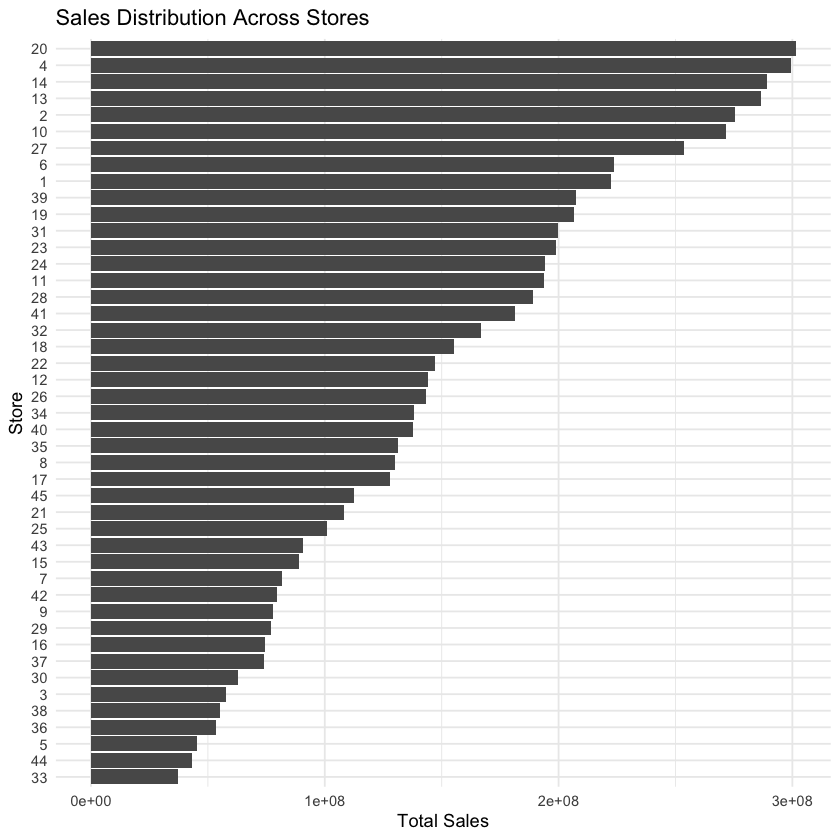

In [56]:
# Aggregate sales by store
store_sales <- train |>
    group_by(Store) |>
    summarize(Total_Sales = sum(Weekly_Sales))

# Plot sales distribution
store_sales |>
    ggplot(aes(x = reorder(as.factor(Store), Total_Sales), y = Total_Sales)) +
    geom_bar(stat = "identity") +
    labs(
        title = "Sales Distribution Across Stores",
        x = "Store",
        y = "Total Sales"
    ) +
    theme_minimal() +
    coord_flip()

In [14]:
install.packages("caret")
library(caret)


set.seed(42)  
train_index <- createDataPartition(combined_data$Weekly_Sales, p = 0.8, list = FALSE)


train_data <- combined_data[train_index, ]
validation_data <- combined_data[-train_index, ]

#Merging Test with Stores
test_data <- merge(test, stores, by = "Store", all.x = TRUE)

# Merge the result with features
test_data <- merge(test_data, features, by = c("Store", "Date"), all.x = TRUE)

# Drop the target variable if present (just in case)
test_data <- test_data[, !(names(test_data) %in% "Weekly_Sales")]



write.csv(train_data, "train_data.csv", row.names = FALSE)
write.csv(validation_data, "validation_data.csv", row.names = FALSE)
write.csv(test_data, "test_data.csv", row.names = FALSE)


The downloaded binary packages are in
	/var/folders/43/bn9297xx5b35xcfsk5bcjf9c0000gn/T//RtmpKauyvi/downloaded_packages
